In [112]:
import pandas as pd
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import ast
from tqdm import tqdm

warnings.filterwarnings("ignore")
plt.style.use('dark_background')

In [113]:
# Use this chunk to generate the dataset if not already created
# df = pd.DataFrame()
# files = os.listdir("./data/patients_new")
# for file in files:
    # patient = pd.read_json(os.path.join("./data/patients_new/", file))
    # df = pd.concat([df, patient], ignore_index=True)
# df.reset_index(drop=True)
# df.to_csv("./collated_dataset.csv", index=False)

df = pd.read_csv("./collated_dataset.csv")

In [114]:
# Take the sub-datasets (patients, hosp, poe, etc.), flatten them and append them to the main dataframe
def normalize_jsons(column, dropper, sorter):
    data = []
    # for each row's json
    for datum in column:
        json_df = pd.json_normalize(ast.literal_eval(datum)[0]) if pd.json_normalize(ast.literal_eval(datum)[0]).iloc[0, 0] else None
        data.append(json_df)
    column_df = pd.concat(data, ignore_index=True).drop_duplicates(subset=dropper).sort_values(by=sorter).reset_index(drop=True)
    return column_df

In [115]:
df = pd.merge(df, normalize_jsons(df["patients"], ["subject_id"], ["anchor_year", "subject_id"]), how='left', on="subject_id", suffixes=("", ""))
df.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,prescriptions,procedures_icd,services,transfers,icustays,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,"[{'subject_id': 10000032, 'hadm_id': 22595853,...","[{'subject_id': 10000032, 'hadm_id': 22595853,...","[{'subject_id': 10000032, 'hadm_id': 22595853,...","[{'subject_id': 10000032, 'hadm_id': 22595853....",[],F,52,2180,2014 - 2016,2180-09-09
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,...,"[{'subject_id': 10000032, 'hadm_id': 22841357,...","[{'subject_id': 10000032, 'hadm_id': 22841357,...","[{'subject_id': 10000032, 'hadm_id': 22841357,...","[{'subject_id': 10000032, 'hadm_id': 22841357....",[],F,52,2180,2014 - 2016,2180-09-09
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,...,"[{'subject_id': 10000032, 'hadm_id': 25742920,...","[{'subject_id': 10000032, 'hadm_id': 25742920,...","[{'subject_id': 10000032, 'hadm_id': 25742920,...","[{'subject_id': 10000032, 'hadm_id': 25742920....",[],F,52,2180,2014 - 2016,2180-09-09
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,...,"[{'subject_id': 10000032, 'hadm_id': 29079034,...",[],"[{'subject_id': 10000032, 'hadm_id': 29079034,...","[{'subject_id': 10000032, 'hadm_id': 29079034....","[{'subject_id': 10000032, 'hadm_id': 29079034,...",F,52,2180,2014 - 2016,2180-09-09
4,10001217,24597018,2157-11-18 22:56:00,2157-11-25 18:00:00,NaN,EW EMER.,P4645A,EMERGENCY ROOM,HOME HEALTH CARE,Other,...,"[{'subject_id': 10001217, 'hadm_id': 24597018,...","[{'subject_id': 10001217, 'hadm_id': 24597018,...","[{'subject_id': 10001217, 'hadm_id': 24597018,...","[{'subject_id': 10001217, 'hadm_id': 24597018....","[{'subject_id': 10001217, 'hadm_id': 24597018,...",F,55,2157,2011 - 2013,


In [116]:
# How do ALOS, medicine delay, number of medicines change with diagnosis severity?
# Are protected attributes more susceptible to certain diseases (eg. description contains liver)
pd.DataFrame(ast.literal_eval(df.loc[0, "drgcodes"]))

,subject_id,hadm_id,drg_type,drg_code,description,drg_severity,drg_mortality
0,10000032,22595853,APR,283,OTHER DISORDERS OF THE LIVER,2.0,2.0
1,10000032,22595853,HCFA,442,"DISORDERS OF LIVER EXCEPT MALIG,CIRR,ALC HEPA ...",,


In [117]:
# Normalize admit and discharge times, and calculate length of stay
df = df.sort_values(by=["admittime"]).reset_index(drop=True)
df['admittime_wy'] = df['admittime'].apply(lambda x: pd.to_datetime(x).replace(year=2024))
df['dischtime_wy'] = df['dischtime'].apply(lambda x: pd.to_datetime(x).replace(year=2024))
df['dischtime_wy'] = df.apply(lambda row: pd.to_datetime(row['dischtime_wy']).replace(year=2025) if row['dischtime_wy'].month < row['admittime_wy'].month else row['dischtime_wy'], axis=1)
df["length_of_stay"] = pd.to_datetime(df["dischtime_wy"]) - pd.to_datetime(df["admittime_wy"])

In [118]:
# Take the sub-datasets (patients, hosp, poe, etc.), flatten them and append them to the main dataframe
def normalize_json_list(column, dropper, sorter):
    data = []
    # for each row's json
    for datum in tqdm(column):
        # convert all the jsons in the list to a set of df columns
        json_df = pd.json_normalize(ast.literal_eval(datum))
        data.append(json_df)
    # compile to a df, drop duplicates and reset index
    column_df = pd.concat(data, ignore_index=True).drop_duplicates(subset=dropper).sort_values(by=sorter).reset_index(drop=True)
    return column_df

In [119]:
df = pd.merge(df, normalize_json_list(df["drgcodes"], ["subject_id", "hadm_id"], ["subject_id", "hadm_id"]), how='left', on=["subject_id", "hadm_id"], suffixes=("", ""))
df.head()

100%|██████████| 275/275 [00:00<00:00, 2919.94it/s]


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,anchor_year_group,dod,admittime_wy,dischtime_wy,length_of_stay,drg_type,drg_code,description,drg_severity,drg_mortality
0,10001725,25563031,2110-04-11 15:08:00,2110-04-14 15:00:00,NaN,EW EMER.,P35SU0,PACU,HOME,Other,...,2011 - 2013,,2024-04-11 15:08:00,2024-04-14 15:00:00,2 days 23:52:00,APR,951.0,MODERATELY EXTENSIVE PROCEDURE UNRELATED TO PR...,2.0,1.0
1,10008454,20291550,2110-11-30 06:31:00,2110-12-10 15:53:00,NaN,EW EMER.,P77BSD,EMERGENCY ROOM,HOME HEALTH CARE,Other,...,2011 - 2013,,2024-11-30 06:31:00,2024-12-10 15:53:00,10 days 09:22:00,HCFA,956.0,"LIMB REATTACHMENT, HIP & FEMUR PROC FOR MULTIP...",,
2,10004422,21255400,2111-01-15 14:55:00,2111-01-25 15:00:00,NaN,EW EMER.,P1037P,PROCEDURE SITE,HOME HEALTH CARE,Medicare,...,2011 - 2013,,2024-01-15 14:55:00,2024-01-25 15:00:00,10 days 00:05:00,APR,165.0,CORONARY BYPASS W AMI OR COMPLEX PDX,3.0,2.0
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,P38TI6,TRANSFER FROM HOSPITAL,DIED,Medicaid,...,2014 - 2016,2111-11-15,2024-11-13 23:39:00,2024-11-15 17:20:00,1 days 17:41:00,APR,260.0,"MAJOR PANCREAS, LIVER & SHUNT PROCEDURES",4.0,4.0
4,10035631,29462354,2112-09-17 19:13:00,2112-10-17 01:41:00,NaN,DIRECT EMER.,P45GUA,PHYSICIAN REFERRAL,HOME,Other,...,2011 - 2013,2116-03-12,2024-09-17 19:13:00,2024-10-17 01:41:00,29 days 06:28:00,HCFA,834.0,ACUTE LEUKEMIA W/O MAJOR O.R. PROCEDURE W MCC,,


In [120]:
# df = pd.merge(df, normalize_json_list(df["emar"], ["subject_id", "hadm_id", "emar_id"], ["subject_id", "charttime"]), how='left', on=["subject_id", "hadm_id"], suffixes=("", "")).drop(["0"], axis=1)
# df["hadm_emar_id"] = df["hadm_id"].apply(lambda x: str(x)) + df["emar_id"].apply(lambda x: str(x))
df.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,anchor_year_group,dod,admittime_wy,dischtime_wy,length_of_stay,drg_type,drg_code,description,drg_severity,drg_mortality
0,10001725,25563031,2110-04-11 15:08:00,2110-04-14 15:00:00,NaN,EW EMER.,P35SU0,PACU,HOME,Other,...,2011 - 2013,,2024-04-11 15:08:00,2024-04-14 15:00:00,2 days 23:52:00,APR,951.0,MODERATELY EXTENSIVE PROCEDURE UNRELATED TO PR...,2.0,1.0
1,10008454,20291550,2110-11-30 06:31:00,2110-12-10 15:53:00,NaN,EW EMER.,P77BSD,EMERGENCY ROOM,HOME HEALTH CARE,Other,...,2011 - 2013,,2024-11-30 06:31:00,2024-12-10 15:53:00,10 days 09:22:00,HCFA,956.0,"LIMB REATTACHMENT, HIP & FEMUR PROC FOR MULTIP...",,
2,10004422,21255400,2111-01-15 14:55:00,2111-01-25 15:00:00,NaN,EW EMER.,P1037P,PROCEDURE SITE,HOME HEALTH CARE,Medicare,...,2011 - 2013,,2024-01-15 14:55:00,2024-01-25 15:00:00,10 days 00:05:00,APR,165.0,CORONARY BYPASS W AMI OR COMPLEX PDX,3.0,2.0
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,P38TI6,TRANSFER FROM HOSPITAL,DIED,Medicaid,...,2014 - 2016,2111-11-15,2024-11-13 23:39:00,2024-11-15 17:20:00,1 days 17:41:00,APR,260.0,"MAJOR PANCREAS, LIVER & SHUNT PROCEDURES",4.0,4.0
4,10035631,29462354,2112-09-17 19:13:00,2112-10-17 01:41:00,NaN,DIRECT EMER.,P45GUA,PHYSICIAN REFERRAL,HOME,Other,...,2011 - 2013,2116-03-12,2024-09-17 19:13:00,2024-10-17 01:41:00,29 days 06:28:00,HCFA,834.0,ACUTE LEUKEMIA W/O MAJOR O.R. PROCEDURE W MCC,,


In [121]:
def plot_histogram(x1, bins, title, x_label, y_label, color1, lcolor1, x2=None, color2=None, lcolor2=None):
    ax = x1.hist(bins=bins, xlabelsize=10, ylabelsize=6, color=color1)
    plt.axvline(x1.median(), color=lcolor1, linestyle='dashed', linewidth=2)

    if x2 is not None:
        ax2 = x2.hist(bins=bins, xlabelsize=10, ylabelsize=6, color=color2)
        plt.axvline(x2.median(), color=lcolor2, linestyle='dashed', linewidth=2)

    ax.set_title(title, weight='bold')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.grid(False)
    plt.show()

In [122]:
# meds = df[(df["medication"] != "") & (df["medication"] != "Sodium Chloride 0.9%  Flush") & (df["event_txt"] == "Administered")]
# meds["medication"].value_counts()

In [123]:
df

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,anchor_year_group,dod,admittime_wy,dischtime_wy,length_of_stay,drg_type,drg_code,description,drg_severity,drg_mortality
0,10001725,25563031,2110-04-11 15:08:00,2110-04-14 15:00:00,NaN,EW EMER.,P35SU0,PACU,HOME,Other,...,2011 - 2013,,2024-04-11 15:08:00,2024-04-14 15:00:00,2 days 23:52:00,APR,951.0,MODERATELY EXTENSIVE PROCEDURE UNRELATED TO PR...,2.0,1.0
1,10008454,20291550,2110-11-30 06:31:00,2110-12-10 15:53:00,NaN,EW EMER.,P77BSD,EMERGENCY ROOM,HOME HEALTH CARE,Other,...,2011 - 2013,,2024-11-30 06:31:00,2024-12-10 15:53:00,10 days 09:22:00,HCFA,956.0,"LIMB REATTACHMENT, HIP & FEMUR PROC FOR MULTIP...",,
2,10004422,21255400,2111-01-15 14:55:00,2111-01-25 15:00:00,NaN,EW EMER.,P1037P,PROCEDURE SITE,HOME HEALTH CARE,Medicare,...,2011 - 2013,,2024-01-15 14:55:00,2024-01-25 15:00:00,10 days 00:05:00,APR,165.0,CORONARY BYPASS W AMI OR COMPLEX PDX,3.0,2.0
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,P38TI6,TRANSFER FROM HOSPITAL,DIED,Medicaid,...,2014 - 2016,2111-11-15,2024-11-13 23:39:00,2024-11-15 17:20:00,1 days 17:41:00,APR,260.0,"MAJOR PANCREAS, LIVER & SHUNT PROCEDURES",4.0,4.0
4,10035631,29462354,2112-09-17 19:13:00,2112-10-17 01:41:00,NaN,DIRECT EMER.,P45GUA,PHYSICIAN REFERRAL,HOME,Other,...,2011 - 2013,2116-03-12,2024-09-17 19:13:00,2024-10-17 01:41:00,29 days 06:28:00,HCFA,834.0,ACUTE LEUKEMIA W/O MAJOR O.R. PROCEDURE W MCC,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,10002930,20846853,2201-02-12 16:58:00,2201-02-13 11:11:00,NaN,EU OBSERVATION,P2358X,PHYSICIAN REFERRAL,NaN,Medicare,...,2011 - 2013,2201-12-24,2024-02-12 16:58:00,2024-02-13 11:11:00,0 days 18:13:00,NaN,NaN,NaN,NaN,NaN
271,10002930,20282368,2201-03-23 19:15:00,2201-03-26 14:24:00,NaN,EU OBSERVATION,P850UN,PHYSICIAN REFERRAL,NaN,Medicare,...,2011 - 2013,2201-12-24,2024-03-23 19:15:00,2024-03-26 14:24:00,2 days 19:09:00,NaN,NaN,NaN,NaN,NaN
272,10026255,22059910,2201-07-07 18:15:00,2201-07-13 23:27:00,2201-07-13 23:27:00,EW EMER.,P48KFD,EMERGENCY ROOM,DIED,Other,...,2011 - 2013,2201-07-13,2024-07-07 18:15:00,2024-07-13 23:27:00,6 days 05:12:00,HCFA,180.0,RESPIRATORY NEOPLASMS W MCC,,
273,10027602,28166872,2201-10-30 12:05:00,2201-11-20 14:45:00,NaN,EW EMER.,P47SIK,EMERGENCY ROOM,REHAB,Other,...,2014 - 2016,,2024-10-30 12:05:00,2024-11-20 14:45:00,21 days 02:40:00,HCFA,20.0,INTRACRANIAL VASCULAR PROCEDURES W PDX HEMORRH...,,


<AxesSubplot:xlabel='drg_code', ylabel='length_of_stay'>

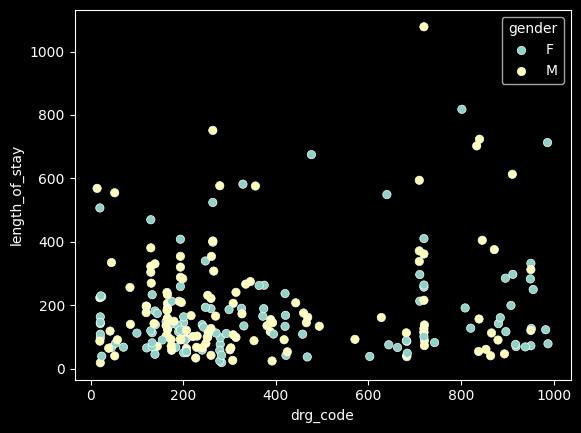

In [124]:
import seaborn as sns

df["length_of_stay"] = df["length_of_stay"].dt.total_seconds() / 3600
sns.scatterplot(data = df, x = 'drg_code', y = 'length_of_stay', hue = 'gender')

In [125]:
from sklearn.model_selection import train_test_split

new_df = df[["admission_type", "admission_location", "discharge_location", "insurance", "marital_status", "race", "hospital_expire_flag", "gender", "anchor_age", "anchor_year", "length_of_stay", "drg_code", "drg_severity", "drg_mortality"]]

encoded_data = new_df
for column_name in ["admission_type", "admission_location", "discharge_location", "insurance", "marital_status", "race", "gender"]:
    one_hot_encoded = pd.get_dummies(encoded_data[column_name], prefix=column_name)
    encoded_data = encoded_data.drop(column_name, axis=1)
    encoded_data = pd.concat([encoded_data, one_hot_encoded], axis=1)
new_df = encoded_data
new_df = new_df.replace("", 0.0)

X_train, X_test, y_train, y_test = train_test_split(new_df, new_df[['hospital_expire_flag']], test_size=0.3, random_state=20)
X_train

,hospital_expire_flag,anchor_age,anchor_year,length_of_stay,drg_code,drg_severity,drg_mortality,admission_type_AMBULATORY OBSERVATION,admission_type_DIRECT EMER.,admission_type_DIRECT OBSERVATION,...,race_OTHER,race_PATIENT DECLINED TO ANSWER,race_PORTUGUESE,race_UNABLE TO OBTAIN,race_UNKNOWN,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - OTHER EUROPEAN,gender_F,gender_M
89,0,81,2141,165.400000,270.0,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
87,0,29,2137,126.366667,952.0,4.0,3.0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
233,0,91,2184,86.533333,20.0,1.0,2.0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
189,0,63,2169,229.266667,22.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
210,1,87,2176,112.466667,254.0,4.0,4.0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,0,58,2153,188.200000,166.0,2.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
71,0,72,2134,67.416667,71.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
218,0,78,2175,90.133333,155.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
223,0,44,2180,65.266667,303.0,0.0,0.0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [126]:
from sklearn import preprocessing

X_train = X_train.dropna()
X_test = X_test.dropna()

X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

In [127]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, random_state = 0, n_init='auto')
kmeans.fit(X_train_norm)

KMeans(n_clusters=3, random_state=0)

<AxesSubplot:xlabel='drg_code', ylabel='length_of_stay'>

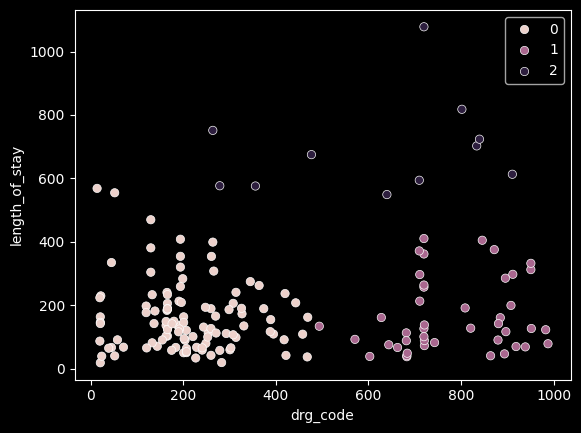

In [128]:
sns.scatterplot(data = X_train, x = 'drg_code', y = 'length_of_stay', hue = kmeans.labels_)

<AxesSubplot:xlabel='anchor_age', ylabel='length_of_stay'>

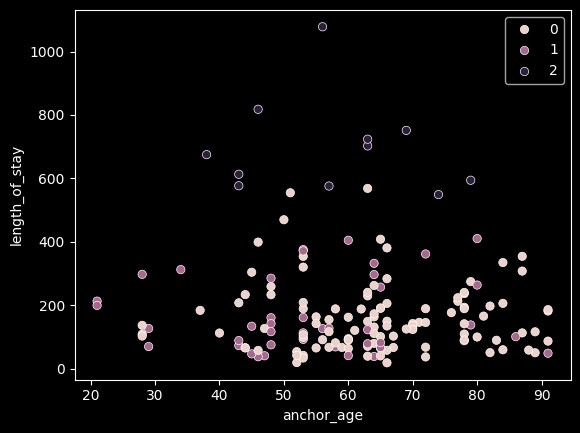

In [129]:
sns.scatterplot(data = X_train, x = 'anchor_age', y = 'length_of_stay', hue = kmeans.labels_)